# The effects of COVID-19 on crime rates in Vancouver

group project proposal:

Sean Lee, Neil Li, Tracy Wang, Wendi Zhong

## Introduction

Before the pandemic, our teammate Neil has experienced no crimes more major than perhaps public drunkeness, but once the pandemic started, he has been subjected to two different attempts of grand theft auto and one shooting. This can't help but make us wonder: is this simply a streak of bad luck or is this the result of the pandemic?

But it wasn't so simple, as research (Nivette et. al., 2021) has shown that crime rate decreases due to lockdowns forcing people to stay in their homes, there are also arguments to be had about how the economic downturn (Munywoki, 2020) could lead more people into commiting crimes for financial reasons.

The result of this could have fascinating ramifications, and it could inform governments on the potential social benefits of providing stimulus cheques.

### Research Question:

<b>Has Covid 19 affected the proportion of financially motivated crimes in Vancouver?<b>
    
### Hypothesis:

$H_0: p_1 - p_2 = 0$ vs $H_1: p_1 - p_2 \neq 0$
    
$\mu_1$: proportion of financially motivated crimes before the pandemic
    
$\mu_2$: proportion of financially motivated crimes after the pandemic

In [1]:
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(grid)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Dataset Info:

The dataset is downloaded from \"[Vancouver Crime Data](https://geodash.vpd.ca/opendata/)\", an open data dataset provided by the Vancouver Police Department. Which we selected to list all the the crimes recorded in every neighbourhood in Vancouver since 2003. The dataset (Vancouver Crime Data) of specific crimes is directly downloaded from the Vancouver Police Department. We are confident that the dataset is trustworthy and representative with no bias in the data; even if there could still be unreported crimes.

In [2]:
# reading data
crimes_url <- "https://raw.githubusercontent.com/NeilLi26/STAT201-project/main/crimedata_csv_AllNeighbourhoods_AllYears.csv"
crime_data <- read.csv(crimes_url)
head(crime_data)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


Because we want to have the crime data be more representative of the difference between the years leading up to the pandemic to the years during and after the pandemic, we will filter the data to only include years from 2017 onwards, and before November since 2022 has not had a November yet. We will also only need the columns containing the type of the crime, year the crime was committed.

In [3]:
# selecting data after 2017 and before November
crime_data_processed <- crime_data %>%
    filter(YEAR >= 2017, MONTH <= 10) %>%
    select(TYPE, YEAR)
head(crime_data_processed)

,TYPE,YEAR
,<chr>,<int>
1,Break and Enter Commercial,2019
2,Break and Enter Commercial,2019
3,Break and Enter Commercial,2021
4,Break and Enter Commercial,2020
5,Break and Enter Commercial,2022
6,Break and Enter Commercial,2022


We then see what kinds of crimes there are, and from the list seen below, we deem the "Breaking and Entering" and "Theft" type crimes to be financially motivated. From the tibble above, and some further research by ourselves, the crimes that would likely be considered as financially motivated would be:

In [4]:
crime_types <- crime_data_processed %>%
    select(TYPE) %>%
    group_by(TYPE) %>%
    summarise(n = n())
crime_types
financial_crimes <- c("Break and Enter Commercial", "Break and Enter Residential/Other", "Other Theft", "Theft from Vehicle",
                     "Theft of Bicycle", "Theft of Vehicle")

TYPE,n
<chr>,<int>
Break and Enter Commercial,11186
Break and Enter Residential/Other,9964
Homicide,77
Mischief,28460
Offence Against a Person,17711
Other Theft,52655
Theft from Vehicle,58279
Theft of Bicycle,10317
Theft of Vehicle,5639


We first decided to visualize the overall spread of crime over the six years by taking a sample of size 2000, and bootstrapping 1000 samples from it to see the overall

In [5]:
# take a single sample with size 2000 from population
set.seed(2190)
sample_size <- 2000

crime_sample <- crime_data_processed %>%
    rep_sample_n(size = sample_size, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))

# create 1000 bootstrap samples with size 2000 of the difference in crimes commited before the pandemic 
# (YEAR < 2020) 
set.seed(2190)
bootstrap_sample <- crime_sample %>%
    rep_sample_n(size = sample_size, reps = 1000, replace = TRUE)%>%
    group_by(replicate,Pandemic)%>%
    summarize(prop = sum(TYPE %in% financial_crimes)/n())%>%
    pivot_wider(names_from = Pandemic, values_from = prop) %>%
    mutate(diff = Before - After) 
    
head(bootstrap_sample)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,After,Before,diff
<int>,<dbl>,<dbl>,<dbl>
1,0.7321637,0.7764192,0.04425547
2,0.6730310,0.7796902,0.10665916
3,0.7051282,0.7845884,0.07946024
4,0.7204059,0.7744834,0.05407752
5,0.6980256,0.7682177,0.07019218
6,0.7209302,0.7827557,0.06182547


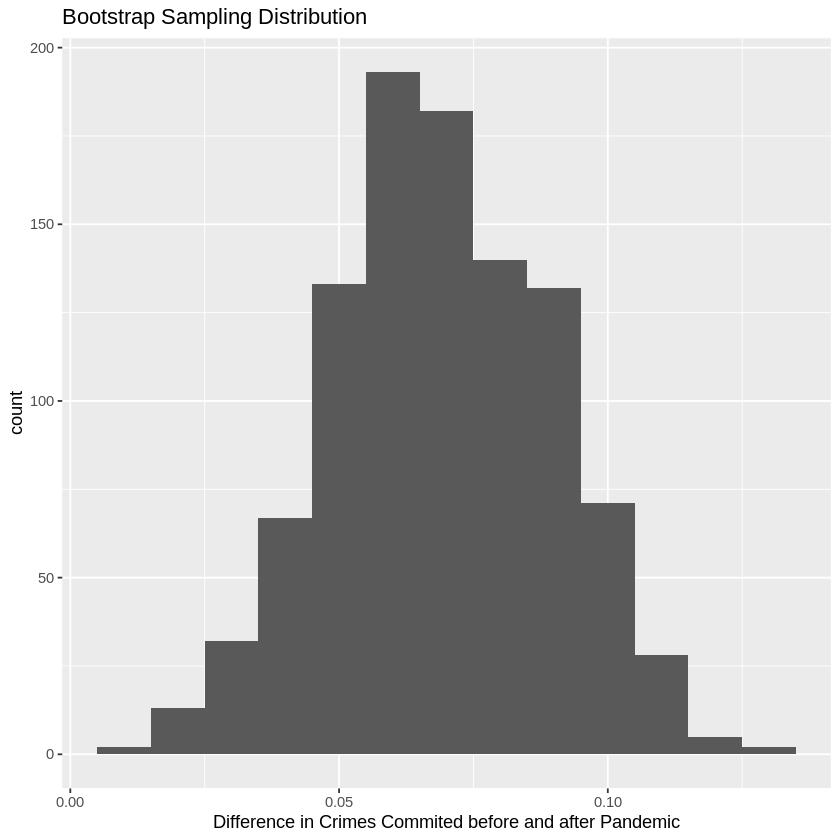

In [6]:
#Visualize the bootstrap distribution
bootstrap_sampling_distribution <- bootstrap_sample%>%
    ggplot(aes(x = diff)) +
    geom_histogram(binwidth = 0.01) +
    xlab("Difference in Crimes Commited before and after Pandemic") +
    ggtitle("Bootstrap Sampling Distribution") 
    
bootstrap_sampling_distribution

In [7]:
# calculate the mean and var of difference in crimes commited
sample_mean <- mean(bootstrap_sample$diff)
sample_var <- var(bootstrap_sample$diff)

#obtain 95% confidence interval 
ci <- bootstrap_sample %>%
    get_ci(level = 0.95, type = "percentile")
bootstrap_Table <- data.frame(sample_mean, sample_var) %>%
    merge(ci)
bootstrap_Table

sample_mean,sample_var,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.06899849,0.0004092966,0.0304651,0.1075528


Because this is a large dataset, we have the luxury of creating many large samples, and with those large samples we could apply the central limit theorem to get more crucial data.

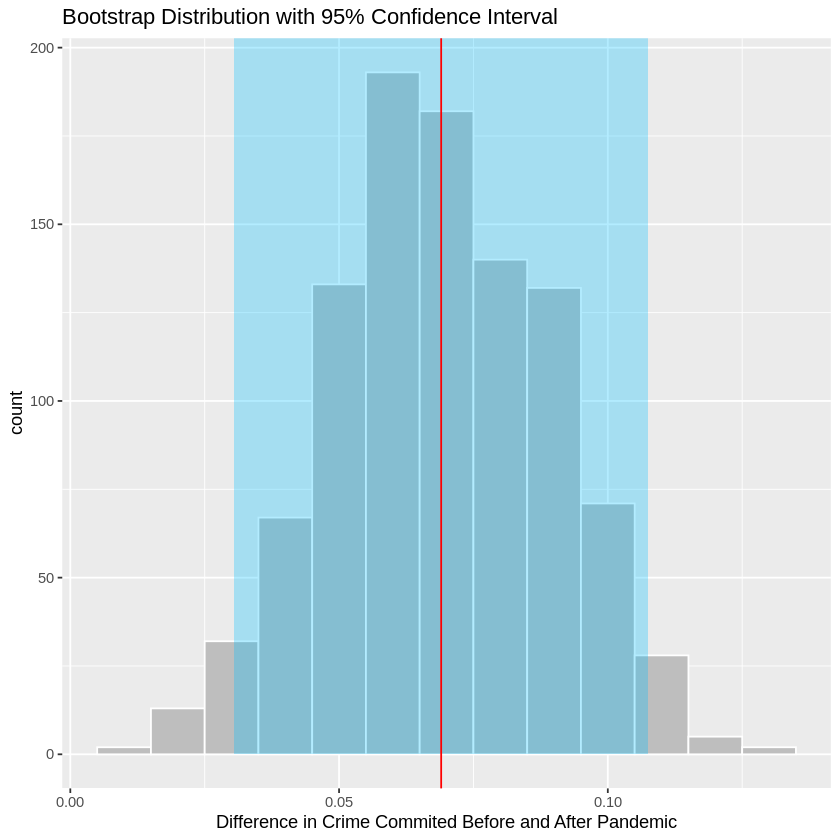

In [8]:
#Visualize the bootstrap distribution with 95% confidence interval
ci_plot <- bootstrap_sample%>%
    ggplot(aes(x = diff)) +
    geom_histogram (binwidth = 0.01, colour = "white", fill = "grey") +
    annotate("rect", xmin = ci$lower_ci, xmax = ci$upper_ci, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    xlab("Difference in Crime Commited Before and After Pandemic")+
    ggtitle("Bootstrap Distribution with 95% Confidence Interval") +
    geom_vline(aes(xintercept= sample_mean), colour = "red")
ci_plot

# Wendi's next step in the project goes here

In [9]:
## make hypothesis test for difference proportions based on bootstrapping methods, see Tutorial 6 question 3 for examples

In [10]:
# take 1000 single sample with size 2000 from population

set.seed(2190)

samples_CLT <- crime_data_processed %>%
    rep_sample_n(size = 2000, reps = 1000, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After"))

head(samples_CLT)

replicate,TYPE,YEAR,Pandemic
<int>,<chr>,<int>,<chr>
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Theft from Vehicle,2018,Before
1,Other Theft,2022,After
1,Mischief,2021,After
1,Theft of Bicycle,2017,Before


`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


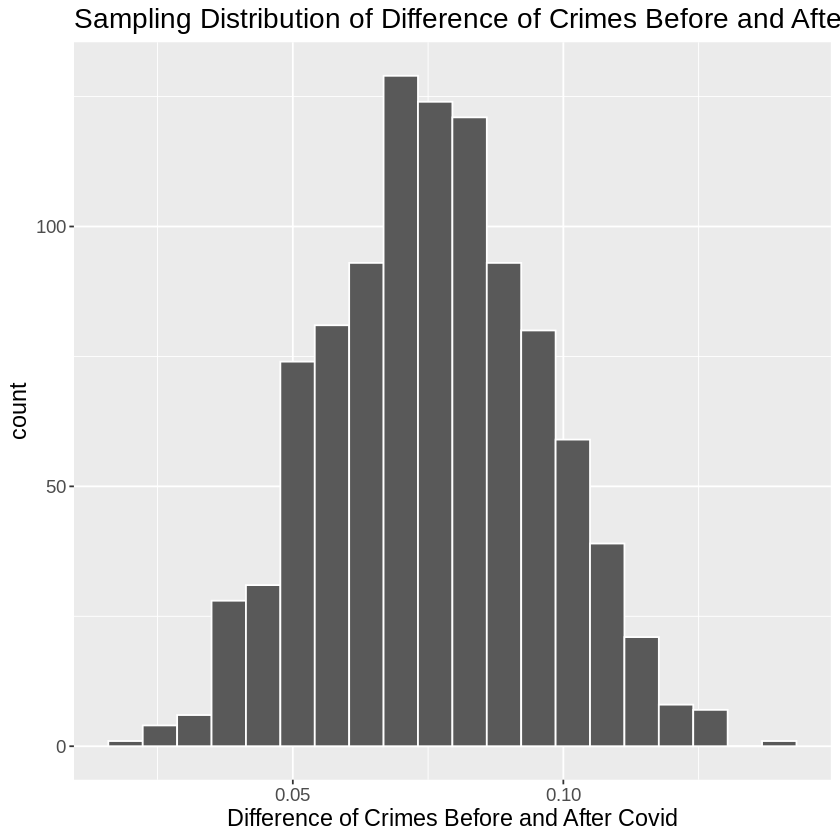

In [11]:
# calculate difference of crimes before and after 2020

diff_sampling_dist_CLT <- 
samples_CLT %>%
    group_by(replicate , Pandemic)%>%
    summarize(prop = sum(TYPE %in% financial_crimes)/n()) %>%
    pivot_wider(names_from = Pandemic, values_from = prop) %>%
    mutate(diff = Before - After) 

# Visualize size 2000 sampling distribution
diff_sampling_dist_plot_CLT <- 
diff_sampling_dist_CLT %>%
   ggplot(aes(x = diff)) +
   geom_histogram(bins = 20, color = 'white') +
   ggtitle("Sampling Distribution of Difference of Crimes Before and After Covid") +
   xlab("Difference of Crimes Before and After Covid") +
   theme(text = element_text(size = 14))
diff_sampling_dist_plot_CLT

In [12]:
# Get mean and var of sampling distribution
mean_CLT <- mean(diff_sampling_dist_CLT$diff)
var_CLT <- var(diff_sampling_dist_CLT$diff)

# Get 95% confidence interval
ci_CLT <- diff_sampling_dist_CLT %>%
            get_confidence_interval(type = "percentile", level = 0.95)

CLT_table <- data.frame(mean_CLT, var_CLT) %>%
    merge(ci_CLT)
CLT_table

mean_CLT,var_CLT,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.07614525,0.0003860956,0.0390271,0.1134796


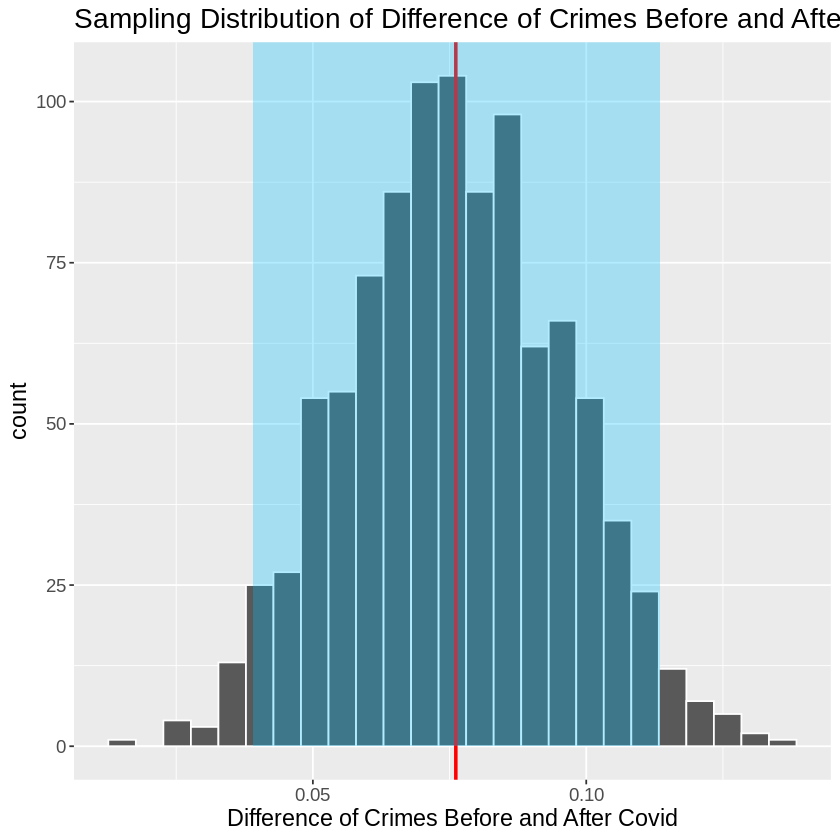

In [13]:
# lab mean on the sampling distribution
# shade 95% confidence interval on the sampling distribution

sample_quantile_plot <- 
    diff_sampling_dist_CLT %>% 
      ggplot(aes(x = diff)) +
      geom_histogram(bins = 25, color = 'white') +
      geom_vline(xintercept = mean_CLT, colour = "red", size = 1) +
      annotate("rect", 
              xmin = ci_CLT$lower_ci,
              xmax = ci_CLT$upper_ci,
              ymin = 0,
              ymax = Inf,
              fill = "deepskyblue",
              alpha = 0.3) +
      ggtitle("Sampling Distribution of Difference of Crimes Before and After Covid") +
      xlab("Difference of Crimes Before and After Covid") +
      theme(text = element_text(size = 14))

sample_quantile_plot

# Tracy's next step in the project goes here

In [19]:
## do hypothesis testing for the difference in proportions based on the central limit theorem, see worksheet 8 question question 3.4 for examples
set.seed(2190)
sample_size <- 2000

samples_hypothesis <- crime_data_processed %>%
    rep_sample_n(size = 2000, reps = 1, replace = FALSE) %>%
    mutate(Pandemic = ifelse(YEAR < 2020, "Before", "After")) %>%
    group_by(replicate,Pandemic) %>%
    summarize(n = n(),
              prop = sum(TYPE %in% financial_crimes)/n())

samples_hypothesis

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,Pandemic,n,prop
<int>,<chr>,<int>,<dbl>
1,After,863,0.7056779
1,Before,1137,0.7748461


In [26]:
n1 <- samples_hypothesis$n[1]
n2 <-samples_hypothesis$n[2]
p1 <- samples_hypothesis$prop[1]
p2 <- samples_hypothesis$prop[2]
p_hat <- (n1*p1 + n2*p2)/(n1 + n2)

test_statistic_theoretical <- (p2 - p1)/sqrt(p_hat * (1 - p_hat) * (1/n1 + 1/n2))

p_score_theoretical <- 2 * pnorm(test_statistic_theoretical, lower.tail = FALSE)
p_score_theoretical

[1] 0.0004397049

## Discussion

# Sean's next step goes here

# References:

Ferguson, E. (2015). Crime and punishment vocabulary with pronunciation. IELTS Liz. Retrieved October 31, 2022, from https://ieltsliz.com/crime-and-punishment-vocabulary/ 

Munywoki, G. (2020). Economic effects of novel coronavirus (COVID – 19) on the global economy. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.3719130 

n.a. (n.d.). Crime Data Download. VPD open data. Retrieved October 31, 2022, from https://geodash.vpd.ca/opendata/ 

Nivette, A.E., Zahnow, R., Aguilar, R. et al. A global analysis of the impact of COVID-19 stay-at-home restrictions on crime. Nat Hum Behav 5, 868–877 (2021). https://doi.org/10.1038/s41562-021-01139-z